Time series provide the opportunity to predict/forecast future values based on previous values. Such analyses can be used to forecast trends in economics, weather, and capacity planning etc. The specific properties of time series data mean that specialized statistical methods are usually required.

### Dataset
"Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001. 

This dataset comes from the statsmodels library


In [2]:
#make necessary imports and initial data #maipulation to visualize the time series
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import itertools
import warnings 
warnings.filterwarnings('ignore')

In [3]:
data = sm.datasets.co2.load().data
df = pd.DataFrame(data)

In [4]:
#update index to datetime type
df['date'] = pd.to_datetime(df['index'])
#set as index
df.set_index(df['date'], inplace=True)

In [5]:
df.drop(['date', 'index'], axis=1, inplace=True)

In [6]:
df.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [7]:
df = df.asfreq('W-SAT')

In [8]:
#'MS' groups the data in buckets by start of the month
co2 = df['co2'].resample('MS').mean()

In [9]:
co2.isna().sum()

5

In [10]:
#filling missing values with values from the next entries -> backfilling
co2.fillna(co2.bfill(), inplace=True)

In [11]:
co2.head()

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

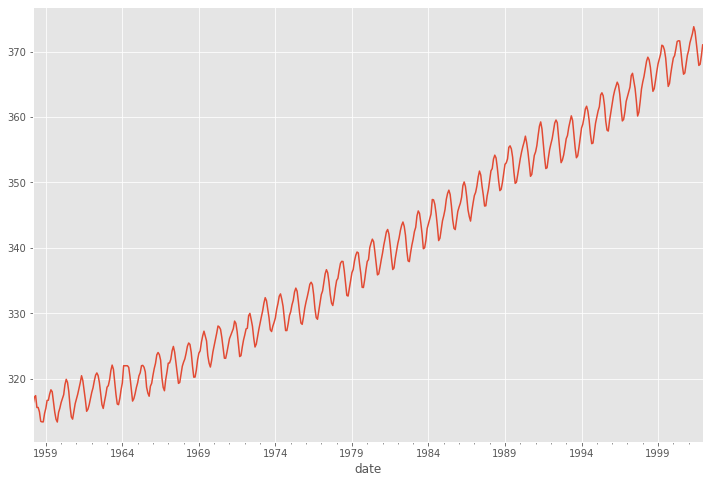

In [12]:
#visualizing the series
co2.plot(figsize=(12,8))
plt.show()

the time series appears to display an overall increasing trend with obvious seasonal pattern

## ARIMA Time Series Model
**A**uto**R**egressive **I**ntegrated **M**oving **A**verage is the most common methods used in time series forecasting. the model can be fit to time series data to better understand or predict future points in the series.

The main parameters of the model are the **p**, **d**, **q** terms. 

Number of AR (Auto-Regressive) terms (p)

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of Differences (d)

d is the Integrated component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last n days is small.

Number of MA (Moving Average) terms (q)

q is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

- (p, d, q) are the non-seasonal parameters described above.
- (P, D, Q) follow the same definition but are applied to the seasonal component of the time series.
- The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.)



In [13]:
#setting up framework for grid search
p = d = q = range(0,3)
#setting up p,d,q values for arima
pdq = list(itertools.product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


In [14]:
#setting up (P,D,Q, 12) for seasonal component
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### AIC (Akaike Information Criterion) as Regularization Measure
For evaluating the models, AIC value shall be used. The AIC is an estimator of the relative quality of the statistical model for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. AIC provides a means for model selection.

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

- Initialize an empty list to store results
- Iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
- Run SARIMAX from statsmodels for each iteration. 
(Setting enforce_stationarity and enforce_invertibility to False)
- Get the results in each iteration with model.fit() and store the AIC values
- Find the lowest AIC and select parameters for further analysis


In [18]:
aic_scores = []
for comb in pdq:
    for combs in pdqs:
        try:
            model = sm.tsa.statespace.SARIMAX(co2,
            order=comb, 
            seasonal_order=combs, 
            enforce_stationarity=False, 
            enforce_invertibility=False)

            output = model.fit()
            aic_scores.append([comb, combs, output.aic])
            print('SARIMA {} X {} : AIC = {}'.format(comb, combs, output.aic))
        except:
            continue
        

AIC = 279.51240537454436
SARIMA (1, 1, 2) X (1, 1, 2, 12) : AIC = 273.6242805784358
SARIMA (1, 1, 2) X (1, 2, 0, 12) : AIC = 801.0847711281726
SARIMA (1, 1, 2) X (1, 2, 1, 12) : AIC = 471.8792415585687
SARIMA (1, 1, 2) X (1, 2, 2, 12) : AIC = 328.8835198485408
SARIMA (1, 1, 2) X (2, 0, 0, 12) : AIC = 430.2799557464241
SARIMA (1, 1, 2) X (2, 0, 1, 12) : AIC = 276.73856784670863
SARIMA (1, 1, 2) X (2, 0, 2, 12) : AIC = 277.75511860123396
SARIMA (1, 1, 2) X (2, 1, 0, 12) : AIC = 358.75970334336625
SARIMA (1, 1, 2) X (2, 1, 1, 12) : AIC = 278.82677457024135
SARIMA (1, 1, 2) X (2, 1, 2, 12) : AIC = 277.31393054147503
SARIMA (1, 1, 2) X (2, 2, 0, 12) : AIC = 647.7667227895056
SARIMA (1, 1, 2) X (2, 2, 1, 12) : AIC = 407.54178429264647
SARIMA (1, 1, 2) X (2, 2, 2, 12) : AIC = 354.4688155157312
SARIMA (1, 2, 0) X (0, 0, 0, 12) : AIC = 1374.845379561458
SARIMA (1, 2, 0) X (0, 0, 1, 12) : AIC = 1174.0210238099567
SARIMA (1, 2, 0) X (0, 0, 2, 12) : AIC = 1051.8434961904554
SARIMA (1, 2, 0) X (0, 

In [19]:
aic_scores = sorted(aic_scores, key=lambda x: x[2])
aic_scores[0]

[(1, 0, 2), (1, 0, 2, 12), 271.25559431225867]

The output of our search suggests that SARIMA(1, 0, 2) X (1, 0, 2, 12) yields the lowest AIC value of 271.26. We should therefore consider this to be optimal option out of all the models we have considered.

### Fitting a SARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model.


In [22]:
# Plug the optimal parameter values into a new SARIMAX model
sarima_model = sm.tsa.statespace.SARIMAX(co2, 
order= (1,0,2), 
seasonal_order=(1,0,2,12), 
enforce_stationarity=False,
enforce_invertibility=False)

# Fit the model and print results
result = sarima_model.fit()

result.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 0, 2)x(1, 0, 2, 12)   Log Likelihood                -128.628
Date:                            Sun, 04 Oct 2020   AIC                            271.256
Time:                                    23:26:23   BIC                            300.744
Sample:                                03-01-1958   HQIC                           282.828
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P&gt;|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9851      0.007    147.822      0.000       0.972       0.998
ma.L1         -0.3242      0.046     -7.089      0.000      -0.414      -0.235
ma.L2         -0.0927      0.036     -2.568      0.010      -0.163      -0.022
ar.S.L12       1.0043      0.000   4967.831      0.000       1.004       1.005
ma.S.L12      -0.8918      0.048    -18.490      0.000      -0.986      -0.797
ma.S.L24      -0.0471      0.049     -0.969      0.332      -0.142       0.048
sigma2         0.0942      0.004     21.102      0.000       0.085       0.103
===================================================================================
Ljung-Box (Q):                       34.59   Jarque-Bera (JB):               214.80
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
&quot;&quot;&quot;

In [24]:
#let's take a closer look at the coefficients
print(result.summary().tables[1])

                 coef    std err          z      P&gt;|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9851      0.007    147.822      0.000       0.972       0.998
ma.L1         -0.3242      0.046     -7.089      0.000      -0.414      -0.235
ma.L2         -0.0927      0.036     -2.568      0.010      -0.163      -0.022
ar.S.L12       1.0043      0.000   4967.831      0.000       1.004       1.005
ma.S.L12      -0.8918      0.048    -18.490      0.000      -0.986      -0.797
ma.S.L24      -0.0471      0.049     -0.969      0.332      -0.142       0.048
sigma2         0.0942      0.004     21.102      0.000       0.085       0.103


The `coef` column above shows the importance of each feature and how each one impacts the time series patterns. The $P>|z|$ provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05, except for the seasonal MA 2nd order, we will reduce the order here and run the SARIMA model again. 

In [34]:
sarima_model2 = sm.tsa.statespace.SARIMAX(co2, order=(1,0,1), seasonal_order=(1, 0, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
result2 = sarima_model2.fit()
result2.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -194.592
Date:                            Sun, 04 Oct 2020   AIC                            399.184
Time:                                    23:47:01   BIC                            420.376
Sample:                                03-01-1958   HQIC                           407.492
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P&gt;|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9618      0.013     74.973      0.000       0.937       0.987
ma.L1         10.3471      3.745      2.763      0.006       3.007      17.687
ar.S.L12       1.0041      0.000   6242.443      0.000       1.004       1.004
ma.S.L12      -1.0774      0.034    -31.707      0.000      -1.144      -1.011
sigma2         0.0010      0.001      1.361      0.174      -0.000       0.002
===================================================================================
Ljung-Box (Q):                       79.61   Jarque-Bera (JB):                45.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
&quot;&quot;&quot;

In [26]:
result2.aic

327.4958412771982

In [31]:
aic_df = pd.DataFrame(aic_scores, columns=['pdq', 'pdqs', 'aic'])
aic_df.head(5)

,pdq,pdqs,aic
0,"(1, 0, 2)","(1, 0, 2, 12)",271.255594
1,"(2, 0, 1)","(1, 0, 2, 12)",271.980414
2,"(0, 1, 0)","(0, 1, 2, 12)",315.378317
3,"(0, 1, 0)","(0, 1, 1, 12)",337.793855
4,"(0, 1, 0)","(1, 0, 1, 12)",376.928376
